### Notebook cleanup
- Unified variable name: `cnn_model` → `model`
- Removed near-duplicate training-loop / adjacent duplicate code cells (conservative heuristic)


# Problem Description: Darcy Flow
**Governing PDE: $\quad −∇⋅(k(x,y)∇u(x,y))=f(x,y),x∈[0,1]$**


**Boundary Condition: $\quad u_{bc}(x,y) = 0, \quad x,y \in [0,1]$**

**Solution Operator: $G : k(x,y) \mapsto u(x,y)$**

branch net 입력: k(x,y)의 센서값</br>
trunk net 입력: x,y 그리드 좌표</br>
출력: 전체 압력장 u(x,y)

Reference: https://github.com/neuraloperator/neuraloperator/tree/main

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from neuralop.data.datasets import DarcyDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [13]:
# 데이터셋 생성 및 로더 설정
dataset = DarcyDataset(
    root_dir="C:/Users/admin/Desktop/김도형/코드/Dataset",
    n_train=2000, n_tests=[20, 20, 20],
    batch_size=50, test_batch_sizes=[20, 20, 20],
    train_resolution=32, test_resolutions=[16, 32, 64],
    download=True
)

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loaders = {res: DataLoader(db, batch_size=20, shuffle=False,
                                num_workers=2, pin_memory=True) 
                for res, db in dataset.test_dbs.items()}

Loading test db for resolution 16 with 20 samples 
Loading test db for resolution 32 with 20 samples 
Loading test db for resolution 64 with 20 samples 


In [14]:
batch = next(iter(train_loader))
print(batch.keys())
for k, v in batch.items():
    print(k, v.shape)

x_data = batch['x'].view(batch['x'].size(0), -1)
print(x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([50, 1, 32, 32])
y torch.Size([50, 1, 32, 32])
torch.Size([50, 1024])


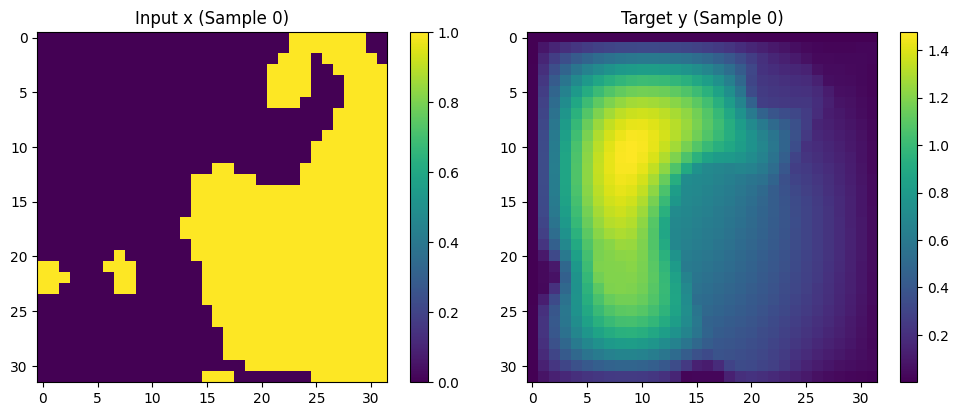

In [15]:
# 샘플 시각화
x_samples, y_samples = batch['x'], batch['y']
sample_idx = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x_samples[sample_idx].squeeze(), cmap='viridis')
axes[0].set_title(f"Input x (Sample {sample_idx})")
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(y_samples[sample_idx].squeeze(), cmap='viridis')
axes[1].set_title(f"Target y (Sample {sample_idx})")
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

In [16]:
class BasicCNN(nn.Module):
    """
    Classic CNN Structure
    Input : (B, 1, 32, 32)
    Output: (B, 1, 32, 32)
    
    특징: Pooling(Downsampling)이나 Upsampling 없이 
          Padding을 사용하여 해상도를 계속 유지함.
    """
    def __init__(self, in_ch=1, out_ch=1, hidden_dim=64, layers=5):
        super().__init__()
        
        modules = []
        
        # 1. 입력층 (Input -> Hidden)
        modules.append(nn.Conv2d(in_ch, hidden_dim, kernel_size=3, padding=1))
        modules.append(nn.GELU()) # 또는 nn.ReLU()
        
        # 2. 은닉층 (Hidden -> Hidden) - 해상도 유지
        for _ in range(layers - 2):
            modules.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1))
            modules.append(nn.GroupNorm(num_groups=8, num_channels=hidden_dim)) # 학습 안정성을 위해 정규화 추가
            modules.append(nn.GELU())
            
        # 3. 출력층 (Hidden -> Output)
        modules.append(nn.Conv2d(hidden_dim, out_ch, kernel_size=3, padding=1))
        
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [17]:
# 1. Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data Loader 준비 (기존 코드의 dataset 객체 활용)
# 위쪽 셀에서 dataset이 이미 로드되어 있어야 합니다.
train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, num_workers=0)
test_loader = dataset.test_dbs[32]  # Resolution 32에 해당하는 로더 추출
test_loader = DataLoader(test_loader, batch_size=10, shuffle=False, num_workers=0)

# 3. 모델 초기화 (U-Net 대신 BasicCNN 사용)
model = BasicCNN(in_ch=1, out_ch=1, hidden_dim=64, layers=6).to(device)
model.apply(init_weights)

# 4. Optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ---------------- Utility Functions ----------------
def ensure_4d(x):
    if x.ndim == 3:
        return x.unsqueeze(1)
    return x

def rel_l2(u_pred, u_true, eps=1e-12):
    # Flatten batch elements to calculate norms
    diff_norms = torch.norm((u_pred - u_true).reshape(u_true.size(0), -1), p=2, dim=1)
    true_norms = torch.norm(u_true.reshape(u_true.size(0), -1), p=2, dim=1).clamp_min(eps)
    return (diff_norms / true_norms).mean().item()

def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    count = 0
    for batch in loader:
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()

        pred = model(x)
        loss = F.mse_loss(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        count += x.size(0)
    return total_loss / count

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    total_loss = 0.0
    total_rel = 0.0
    count = 0
    for batch in loader:
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()
        
        pred = model(x)
        loss = F.mse_loss(pred, y, reduction="mean").item()
        r = rel_l2(pred, y)

        bs = x.size(0)
        total_loss += loss * bs
        total_rel  += r * bs
        count += bs
    return total_loss / count, total_rel / count

# ---------------- Training Loop ----------------
num_epochs = 200
print(f"Model: BasicCNN | Params: {sum(p.numel() for p in model.parameters())}")

for ep in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(train_loader)
    te_loss, te_rel = eval_loader(test_loader)
    scheduler.step()

    if ep % 10 == 0 or ep == 1:
        print(f"[{ep:03d}] Train MSE: {tr_loss:.4e} | Test MSE: {te_loss:.4e} | Test Rel L2: {te_rel*100:.2f}%")

Model: BasicCNN | Params: 149441
[001] Train MSE: 1.4428e-01 | Test MSE: 7.1772e-02 | Test Rel L2: 46.83%
[010] Train MSE: 1.9041e-02 | Test MSE: 2.6436e-02 | Test Rel L2: 30.22%
[020] Train MSE: 1.6768e-02 | Test MSE: 1.6852e-02 | Test Rel L2: 23.90%
[030] Train MSE: 1.6534e-02 | Test MSE: 1.6524e-02 | Test Rel L2: 22.83%
[040] Train MSE: 1.4637e-02 | Test MSE: 1.4568e-02 | Test Rel L2: 22.40%
[050] Train MSE: 1.3259e-02 | Test MSE: 1.3398e-02 | Test Rel L2: 21.57%
[060] Train MSE: 1.2410e-02 | Test MSE: 1.3222e-02 | Test Rel L2: 21.09%
[070] Train MSE: 1.2219e-02 | Test MSE: 1.3148e-02 | Test Rel L2: 20.69%
[080] Train MSE: 1.1979e-02 | Test MSE: 1.2596e-02 | Test Rel L2: 19.78%
[090] Train MSE: 1.1431e-02 | Test MSE: 1.3062e-02 | Test Rel L2: 21.68%
[100] Train MSE: 1.1274e-02 | Test MSE: 1.1468e-02 | Test Rel L2: 19.37%
[110] Train MSE: 1.0493e-02 | Test MSE: 1.0643e-02 | Test Rel L2: 18.75%
[120] Train MSE: 1.0419e-02 | Test MSE: 1.0768e-02 | Test Rel L2: 18.73%
[130] Train MSE: 1

In [7]:
# =========================
# 3) Run Training
# =========================
num_epochs = 200
test_loader = test_loaders[32]
for ep in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(train_loader)
    te_loss, te_rel = eval_loader(test_loader)
    scheduler.step()

    if ep % 10 == 0 or ep == 1:
        print(f"[{ep:03d}] train_mse={tr_loss:.4e} | test_mse={te_loss:.4e} | test_relL2={te_rel:.4f}")
        torch.save(model.state_dict(), "C:/Users/admin/Desktop/김도형/코드/model/darcy_cnn_autosave.pt")


[001] train_mse=9.6280e-03 | test_mse=1.0574e-02 | test_relL2=0.1855
[010] train_mse=9.5484e-03 | test_mse=1.1017e-02 | test_relL2=0.1857
[020] train_mse=9.4867e-03 | test_mse=1.0371e-02 | test_relL2=0.1844
[030] train_mse=9.4434e-03 | test_mse=1.0789e-02 | test_relL2=0.1878
[040] train_mse=9.4303e-03 | test_mse=1.1134e-02 | test_relL2=0.1858
[050] train_mse=9.3223e-03 | test_mse=1.0648e-02 | test_relL2=0.1832
[060] train_mse=9.2475e-03 | test_mse=1.0564e-02 | test_relL2=0.1835
[070] train_mse=9.1724e-03 | test_mse=1.0290e-02 | test_relL2=0.1824
[080] train_mse=9.1835e-03 | test_mse=1.0490e-02 | test_relL2=0.1817
[090] train_mse=9.1412e-03 | test_mse=1.0244e-02 | test_relL2=0.1811
[100] train_mse=9.1000e-03 | test_mse=1.0180e-02 | test_relL2=0.1817
[110] train_mse=9.0118e-03 | test_mse=1.0163e-02 | test_relL2=0.1815
[120] train_mse=9.0105e-03 | test_mse=1.0085e-02 | test_relL2=0.1811
[130] train_mse=8.9762e-03 | test_mse=1.0112e-02 | test_relL2=0.1813
[140] train_mse=8.9778e-03 | test_

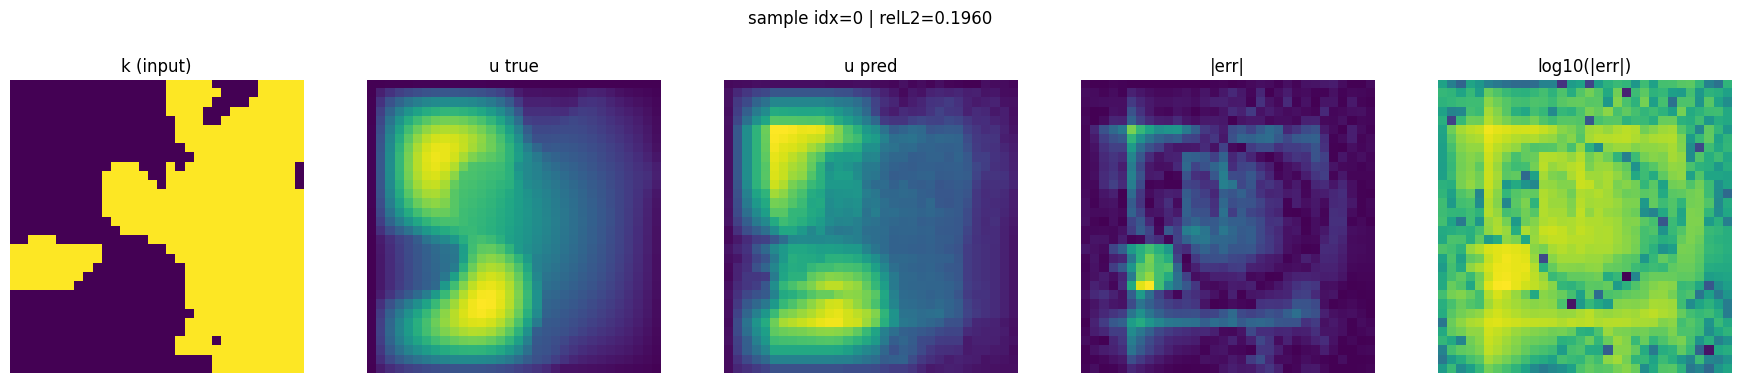

In [21]:
# =========================
# 4) Visualization (k, u_true, u_pred, error, log-error)
# =========================
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_sample(loader, idx=0, eps=1e-12):
    model.eval()
    batch = next(iter(loader))
    x = ensure_4d(batch["x"]).float()
    y = ensure_4d(batch["y"]).float()

    # pick sample
    x1 = x[idx:idx+1].to(device)
    y1 = y[idx:idx+1].to(device)
    pred = model(x1)

    k_np = x1.squeeze().detach().cpu().numpy()       # (H,W)
    u_true = y1.squeeze().detach().cpu().numpy()
    u_pred = pred.squeeze().detach().cpu().numpy()
    err = np.abs(u_pred - u_true)
    log_err = np.log10(err + eps)

    rel = np.linalg.norm((u_pred - u_true).ravel()) / (np.linalg.norm(u_true.ravel()) + eps)

    fig, axs = plt.subplots(1, 5, figsize=(18, 3.6))
    axs[0].imshow(k_np);      axs[0].set_title("k (input)"); axs[0].axis("off")
    axs[1].imshow(u_true);    axs[1].set_title("u true");    axs[1].axis("off")
    axs[2].imshow(u_pred);    axs[2].set_title("u pred");    axs[2].axis("off")
    axs[3].imshow(err);       axs[3].set_title("|err|");     axs[3].axis("off")
    axs[4].imshow(log_err);   axs[4].set_title("log10(|err|)"); axs[4].axis("off")
    plt.suptitle(f"sample idx={idx} | relL2={rel:.4f}", y=1.05)
    plt.tight_layout()
    plt.show()

# 사용 예:
visualize_sample(test_loader, idx=0)


In [22]:
import torch
import numpy as np

@torch.no_grad()
def print_all_relative_errors(loader, eps=1e-12):
    model.eval()
    
    sample_idx = 0
    print(f"{'Sample Index':<15} | {'Relative L2 Error (%)':<20}")
    print("-" * 40)

    for batch in loader:
        # 데이터 로드 및 4D 보장
        x = ensure_4d(batch["x"]).to(device).float()
        y = ensure_4d(batch["y"]).to(device).float()
        
        # 모델 예측
        pred = model(x)
        
        # 배치 내의 각 샘플에 대해 오차 계산
        # (batch_size, 1, H, W) -> (batch_size, H*W) 형태로 펼쳐서 계산하면 편리합니다.
        y_flat = y.view(y.size(0), -1).cpu().numpy()
        pred_flat = pred.view(pred.size(0), -1).cpu().numpy()
        
        for i in range(len(y_flat)):
            true_sample = y_flat[i]
            pred_sample = pred_flat[i]
            
            # L2 상대 오차 계산
            diff_norm = np.linalg.norm(true_sample - pred_sample)
            true_norm = np.linalg.norm(true_sample)
            
            rel_l2 = (diff_norm / (true_norm + eps)) * 100
            
            print(f"Sample {sample_idx:<8} | {rel_l2:.4f}%")
            sample_idx += 1

    print("-" * 40)
    print(f"Total samples processed: {sample_idx}")

# 사용 예:
print_all_relative_errors(test_loader)

Sample Index    | Relative L2 Error (%)
----------------------------------------
Sample 0        | 19.6044%
Sample 1        | 19.4002%
Sample 2        | 20.1723%
Sample 3        | 16.5784%
Sample 4        | 17.0957%
Sample 5        | 17.4293%
Sample 6        | 24.4138%
Sample 7        | 18.7230%
Sample 8        | 16.1009%
Sample 9        | 19.7557%
Sample 10       | 15.6366%
Sample 11       | 17.4704%
Sample 12       | 9.3947%
Sample 13       | 29.9589%
Sample 14       | 26.4885%
Sample 15       | 13.4884%
Sample 16       | 17.3825%
Sample 17       | 14.2697%
Sample 18       | 13.3452%
Sample 19       | 15.5219%
----------------------------------------
Total samples processed: 20



[BasicCNN] Testing Resolution: 16x16 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_cnn_autosave.pt)


C:\Users\admin\AppData\Local\Temp\ipykernel_6324\2628494891.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['23.39%', '21.45%', '24.71%', '20.79%', '18.52%', '17.26%', '23.30%', '22.36%', '18.97%', '23.28%', '16.13%', '19.98%', '15.91%', '34.56%', '22.35%', '22.20%', '19.24%', '19.74%', '18.43%', '20.62%']
평균 Relative L2 Error: 21.16%


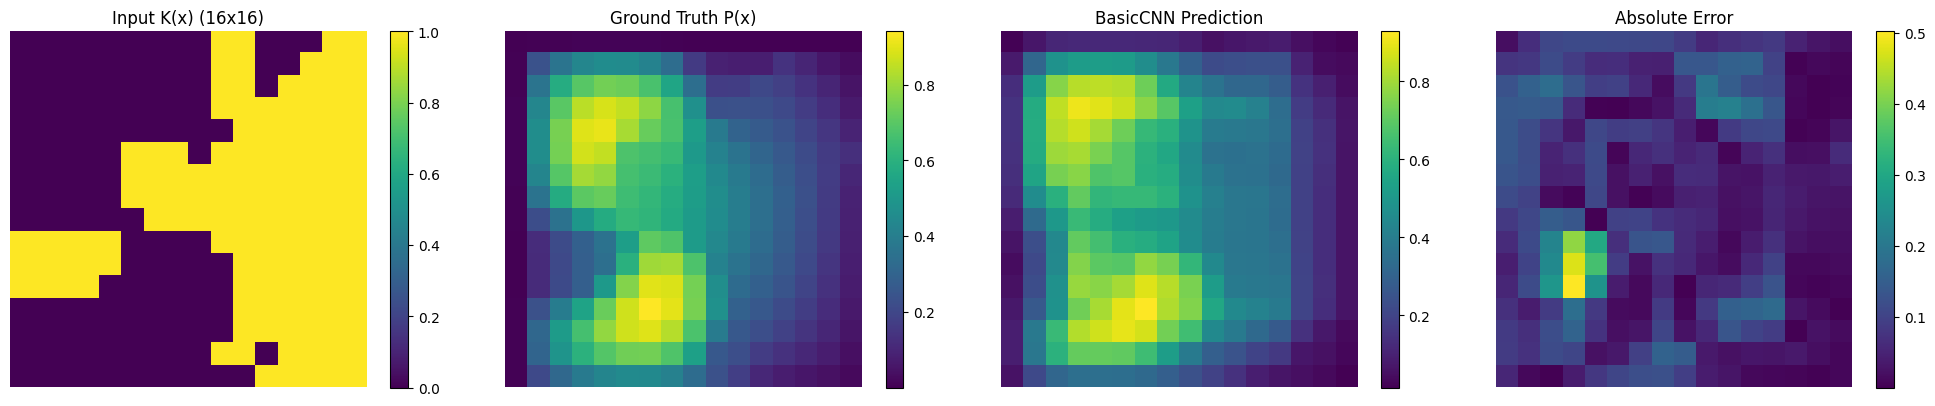

------------------------------------------------------------

[BasicCNN] Testing Resolution: 32x32 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_cnn_autosave.pt)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['22.18%', '19.65%', '21.20%', '17.06%', '16.38%', '18.27%', '25.08%', '18.46%', '14.53%', '19.92%', '14.03%', '16.69%', '10.25%', '30.78%', '23.70%', '13.83%', '16.16%', '14.20%', '13.83%', '16.43%']
평균 Relative L2 Error: 18.13%


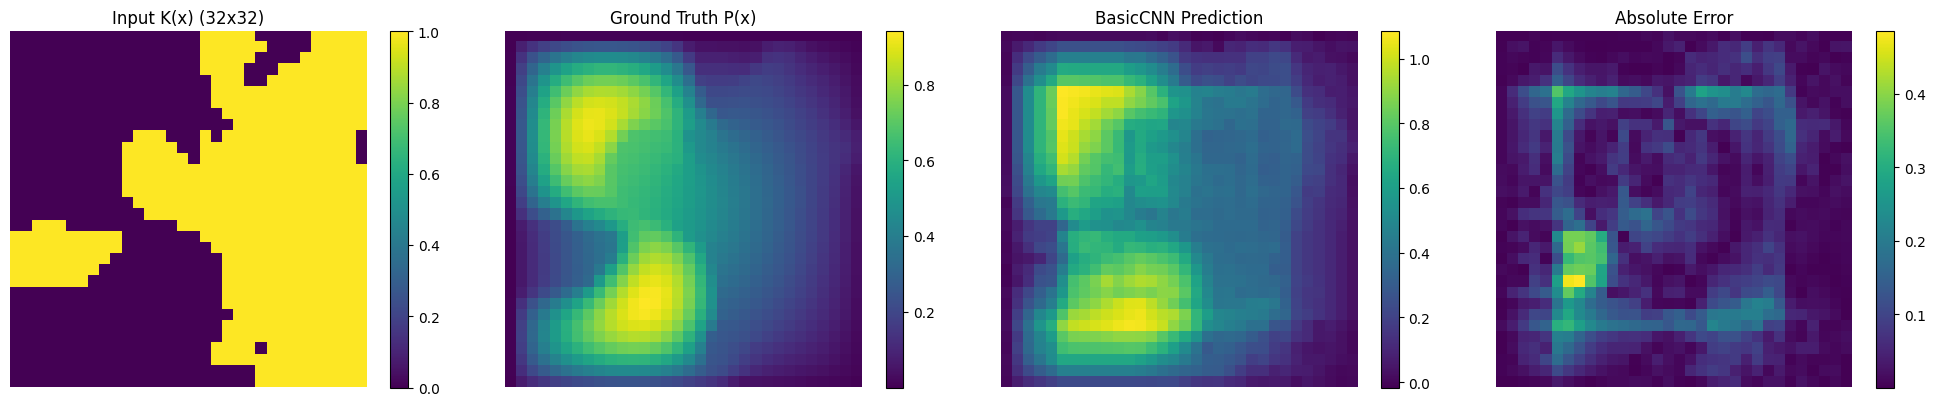

------------------------------------------------------------

[BasicCNN] Testing Resolution: 64x64 (Model: C:/Users/admin/Desktop/김도형/코드/model/darcy_cnn_autosave.pt)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['18.26%', '20.41%', '19.81%', '17.14%', '15.82%', '18.14%', '20.81%', '17.35%', '14.10%', '17.39%', '12.61%', '15.22%', '10.97%', '30.20%', '24.81%', '14.47%', '15.23%', '16.15%', '13.02%', '17.97%']
평균 Relative L2 Error: 17.49%


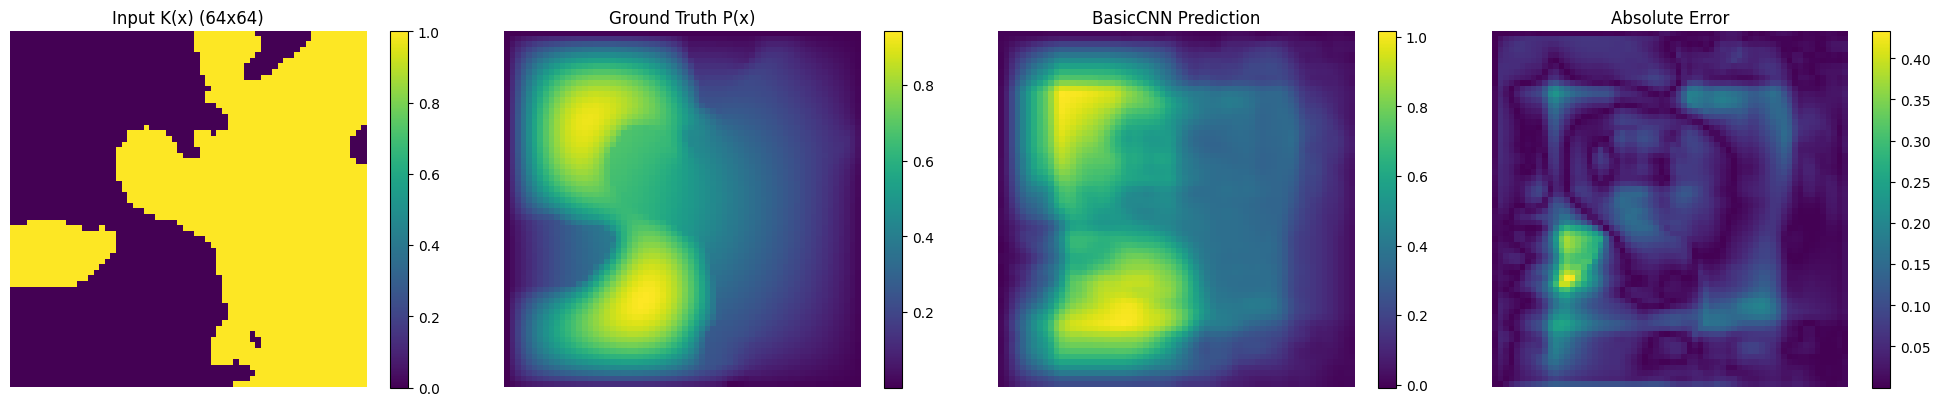

------------------------------------------------------------


In [26]:
import torch.nn.functional as F
def test_basic_cnn(model_path, resolution, data_loader):
    print(f"\n[BasicCNN] Testing Resolution: {resolution}x{resolution} (Model: {model_path})")
    
    # 모델 초기화 (학습 시 설정한 파라미터와 일치해야 함: layers=6)
    model = BasicCNN(in_ch=1, out_ch=1, hidden_dim=64, layers=6).to(device)
    
    # 가중치 로드
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    l2_errors = []
    vis_input, vis_true, vis_pred = None, None, None
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            # --- 해상도 보정 (CNN 입력 고정: 32x32) ---
            if x.shape[-1] != 32:
                x_in = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
            else:
                x_in = x
                
            # 예측
            out = model(x_in)
            
            # --- 출력을 원래 해상도로 복원 ---
            if out.shape[-1] != resolution:
                out_resized = F.interpolate(out, size=(resolution, resolution), mode='bilinear', align_corners=False)
            else:
                out_resized = out
            
            # 오차 계산
            pred_flat = out_resized.view(out_resized.size(0), -1)
            true_flat = y.view(y.size(0), -1)
            
            diff_norm = torch.norm(pred_flat - true_flat, p=2, dim=1)
            true_norm = torch.norm(true_flat, p=2, dim=1)
            batch_errors = diff_norm / (true_norm + 1e-6)
            
            l2_errors.extend(batch_errors.cpu().tolist())
            
            if i == 0:
                vis_input = x[0, 0].cpu().numpy()
                vis_true = y[0, 0].cpu().numpy()
                vis_pred = out_resized[0, 0].cpu().numpy()

    # 결과 출력
    avg_error = np.mean(l2_errors)
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    formatted_errors = [f"{e*100:05.2f}%" for e in l2_errors]
    print(f"전체 샘플 Relative L2 Error: {formatted_errors}")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")
    
    # 시각화
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    abs_error = np.abs(vis_true - vis_pred)
    
    titles = [f'Input K(x) ({resolution}x{resolution})', 
              'Ground Truth P(x)', 
              'BasicCNN Prediction', 
              'Absolute Error']
    images = [vis_input, vis_true, vis_pred, abs_error]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_cnn_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("-" * 60)


model_file = "C:/Users/admin/Desktop/김도형/코드/model/darcy_cnn_autosave.pt"

test_basic_cnn(model_file, 16, test_loaders[16])
test_basic_cnn(model_file, 32, test_loaders[32])
test_basic_cnn(model_file, 64, test_loaders[64])